In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torch.optim as optim

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

##Dataset Preparation

In [10]:
class FaceMaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load images and labels
        classes = ['with_mask', 'without_mask']
        for class_idx, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Create dataset
dataset = FaceMaskDataset(root_dir='data', transform=data_transforms)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 6042
Validation samples: 1511


In [11]:
# Basic convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

# Classification head
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes=2):
        super(ClassifierHead, self).__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
class FaceMaskCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FaceMaskCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            ConvBlock(3, 32),  # 128x128 -> 64x64
            ConvBlock(32, 64), # 64x64 -> 32x32
            ConvBlock(64, 128), # 32x32 -> 16x16
            ConvBlock(128, 256), # 16x16 -> 8x8
            ConvBlock(256, 512) # 8x8 -> 4x4
        )
        
        # Classifier
        self.classifier = ClassifierHead(512 * 4 * 4, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Create model
model = FaceMaskCNN(num_classes=2).to(device)
print(model)

FaceMaskCNN(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )


In [13]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        print('-' * 20)
    
    return train_losses, val_losses, train_accs, val_accs

c:\Users\13th\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/25:
Train Loss: 1.2971, Train Acc: 0.8136
Val Loss: 0.2281, Val Acc: 0.9073
--------------------
Epoch 2/25:
Train Loss: 0.2733, Train Acc: 0.9012
Val Loss: 0.1560, Val Acc: 0.9437
--------------------
Epoch 3/25:
Train Loss: 0.1913, Train Acc: 0.9303
Val Loss: 0.2972, Val Acc: 0.8815
--------------------
Epoch 4/25:
Train Loss: 0.1784, Train Acc: 0.9368
Val Loss: 0.1487, Val Acc: 0.9457
--------------------
Epoch 5/25:
Train Loss: 0.1555, Train Acc: 0.9503
Val Loss: 0.1374, Val Acc: 0.9490
--------------------
Epoch 6/25:
Train Loss: 0.1524, Train Acc: 0.9487
Val Loss: 0.1188, Val Acc: 0.9623
--------------------
Epoch 7/25:
Train Loss: 0.1438, Train Acc: 0.9550
Val Loss: 0.0910, Val Acc: 0.9603
--------------------
Epoch 8/25:
Train Loss: 0.1352, Train Acc: 0.9571
Val Loss: 0.3478, Val Acc: 0.8795
--------------------
Epoch 9/25:
Train Loss: 0.1136, Train Acc: 0.9652
Val Loss: 0.1392, Val Acc: 0.9570
--------------------
Epoch 10/25:
Train Loss: 0.0997, Train Acc: 0.9672
Val 

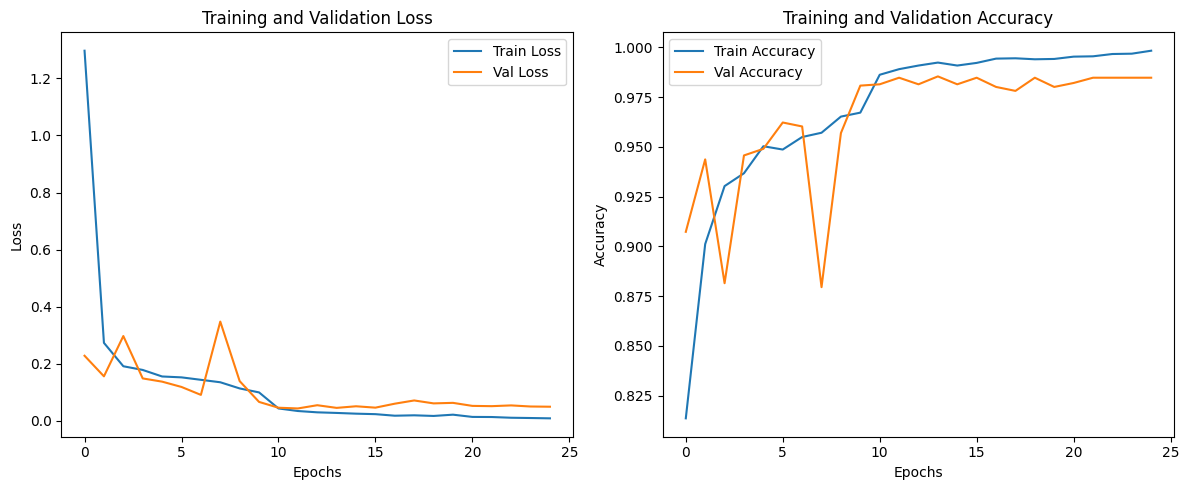

In [14]:
# Train the model
num_epochs = 25
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    
    return all_preds, all_labels, accuracy

# Evaluate the model
test_predictions, test_labels, test_accuracy = evaluate_model(model, val_loader)

Test Accuracy: 0.9835


In [16]:
def predict_image(model, image_path, transform):
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probability = F.softmax(outputs, dim=1)
    
    # Get class label and confidence
    class_names = ['with_mask', 'without_mask']
    predicted_class = class_names[predicted.item()]
    confidence = probability[0][predicted.item()].item()
    
    return predicted_class, confidence

# Example usage
# prediction, confidence = predict_image(model, 'path/to/image.jpg', data_transforms)
# print(f'Prediction: {prediction}, Confidence: {confidence:.4f}')

In [17]:
# Install required packages for TFLite conversion
!pip install onnx onnx-tf tensorflow

# 11. Save the model in TensorFlow Lite format
def save_model_tflite(model, input_size=(1, 3, 128, 128), save_path='face_mask_model.tflite'):
    """
    Save PyTorch model in TensorFlow Lite format using ONNX conversion
    """
    try:
        import onnx
        from onnx_tf.backend import prepare
        import tensorflow as tf
        import numpy as np
        
        print("Converting PyTorch model to TensorFlow Lite...")
        
        # Create dummy input
        dummy_input = torch.randn(*input_size).to(device)
        
        # Step 1: Export to ONNX format
        onnx_path = 'temp_model.onnx'
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
        )
        print("✓ Model exported to ONNX format")
        
        # Step 2: Convert ONNX to TensorFlow
        onnx_model = onnx.load(onnx_path)
        tf_rep = prepare(onnx_model)
        print("✓ ONNX model converted to TensorFlow")
        
        # Step 3: Convert to TensorFlow Lite
        converter = tf.lite.TFLiteConverter.from_concrete_functions([tf_rep.tf_module.signatures['serving_default']])
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
            tf.lite.OpsSet.SELECT_TF_OPS     # enable TensorFlow ops.
        ]
        converter.allow_custom_ops = True
        
        # Convert the model
        tflite_model = converter.convert()
        
        # Save the TFLite model
        with open(save_path, 'wb') as f:
            f.write(tflite_model)
        
        print(f"✓ Model saved as TensorFlow Lite: {save_path}")
        
        # Clean up temporary files
        import os
        if os.path.exists(onnx_path):
            os.remove(onnx_path)
        
        return True
        
    except ImportError as e:
        print(f"Required packages not installed: {e}")
        return False
    except Exception as e:
        print(f"Error converting to TFLite format: {e}")
        return False

# Save model in TFLite format
save_model_tflite(model, save_path='face_mask_model.tflite')

INFO: pip is looking at multiple versions of onnx-tf to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   -------------

False

In [18]:
# 12. Enhanced TFLite conversion with quantization
def save_model_tflite_optimized(model, input_size=(1, 3, 128, 128), save_path='face_mask_model_quantized.tflite'):
    """
    Save optimized TFLite model with quantization
    """
    try:
        import onnx
        from onnx_tf.backend import prepare
        import tensorflow as tf
        import numpy as np
        
        print("Converting to optimized TensorFlow Lite model...")
        
        # Create dummy input
        dummy_input = torch.randn(*input_size).to(device)
        
        # Export to ONNX
        onnx_path = 'temp_model.onnx'
        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=11,
            input_names=['input'],
            output_names=['output']
        )
        
        # Convert ONNX to TensorFlow
        onnx_model = onnx.load(onnx_path)
        tf_rep = prepare(onnx_model)
        
        # Create a representative dataset for quantization
        def representative_dataset():
            for _ in range(100):
                data = np.random.rand(1, 3, 128, 128).astype(np.float32)
                yield [data]
        
        # Convert to TFLite with quantization
        converter = tf.lite.TFLiteConverter.from_concrete_functions([tf_rep.tf_module.signatures['serving_default']])
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        
        tflite_quant_model = converter.convert()
        
        # Save the quantized model
        with open(save_path, 'wb') as f:
            f.write(tflite_quant_model)
        
        print(f"✓ Optimized TFLite model saved: {save_path}")
        
        # Clean up
        import os
        if os.path.exists(onnx_path):
            os.remove(onnx_path)
            
        return True
        
    except Exception as e:
        print(f"Error in optimized conversion: {e}")
        return False

# Save optimized TFLite model
save_model_tflite_optimized(model)

Error in optimized conversion: cannot import name 'mapping' from 'onnx' (c:\Users\13th\AppData\Local\Programs\Python\Python312\Lib\site-packages\onnx\__init__.py)


False

In [19]:
# 13. Test the TFLite model
def test_tflite_model(tflite_model_path='face_mask_model.tflite'):
    """
    Test the converted TFLite model
    """
    try:
        import tensorflow as tf
        import numpy as np
        from PIL import Image
        
        # Load TFLite model
        interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
        interpreter.allocate_tensors()
        
        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        print("TFLite Model Details:")
        print(f"Input details: {input_details[0]}")
        print(f"Output details: {output_details[0]}")
        
        # Create test input
        test_input = np.random.randn(1, 3, 128, 128).astype(np.float32)
        
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], test_input)
        
        # Run inference
        interpreter.invoke()
        
        # Get output
        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        print("✓ TFLite model test successful!")
        print(f"Output shape: {output_data.shape}")
        print(f"Sample output: {output_data[0][:5]}")  # First 5 values
        
        return True
        
    except Exception as e:
        print(f"Error testing TFLite model: {e}")
        return False

# Test the TFLite model
test_tflite_model()

Error testing TFLite model: Could not open 'face_mask_model.tflite'.


c:\Users\13th\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


False